In [26]:
import pandas as pd
import numpy as np
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
# import the time module
import time

In [45]:
df =pd.read_parquet('yellow_tripdata_2023-01.parquet', engine='fastparquet')
Staten_Island_trips = df[df['PULocationID'].isin(staten_island_zones['LocationID']) & df['DOLocationID'].isin(staten_island_zones['LocationID'])].reset_index()
Staten_Island_trips.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,15145,2,2023-01-01 03:17:04,2023-01-01 10:17:20,1.0,22.21,1.0,N,156,156,4,-346.0,-1.0,-0.5,0.0,0.0,-1.0,-351.0,-2.5,0.0
1,15146,2,2023-01-01 03:17:04,2023-01-01 10:17:20,1.0,22.21,1.0,N,156,156,4,346.0,1.0,0.5,0.0,0.0,1.0,351.0,2.5,0.0
2,20897,2,2023-01-01 05:57:27,2023-01-01 05:57:32,1.0,0.07,1.0,N,6,6,2,3.0,1.0,0.5,0.0,0.0,1.0,5.5,0.0,0.0
3,75816,2,2023-01-02 03:15:11,2023-01-02 03:15:15,1.0,0.04,1.0,N,6,6,2,3.0,1.0,0.5,0.0,0.0,1.0,5.5,0.0,0.0
4,77101,1,2023-01-02 06:05:33,2023-01-02 06:17:02,1.0,0.00,1.0,N,251,23,1,24.2,0.0,0.5,0.0,0.0,1.0,25.7,0.0,0.0


In [79]:
df3 = pd.DataFrame(df['DOLocationID'].value_counts())
df3 = df3.sort_values(by = 'DOLocationID', ascending = True)
df3

,count
DOLocationID,
1,699
2,4
3,11
4,449
5,3
...,...
261,633
262,1670
263,2488


In [49]:
df2 = pd.read_csv("taxi+_zone_lookup.csv")
staten_island_zones = df2[df2['Borough'] == "Staten Island"].reset_index(drop = True)
positions = {5: (0, 0), 6: (5,3), 23: (0,3), 44: (-2,-1), 84: (0, -1), 99:(0,1), 109:(2,0), 110:(3,0), 115:(4, 3),
   118:(2 , 1.5), 156:(4, 1), 172:(4, 0.5), 176:(1, 4), 187:(2, 4), 204:(-1, -.25), 206:(4, 4), 
  214:(4.25, 1), 221:(5, 3.5), 245:(4.5, 2.75), 251:(2.5, 2)}
staten_island_zones


,LocationID,Borough,Zone,service_zone
0,5,Staten Island,Arden Heights,Boro Zone
1,6,Staten Island,Arrochar/Fort Wadsworth,Boro Zone
2,23,Staten Island,Bloomfield/Emerson Hill,Boro Zone
3,44,Staten Island,Charleston/Tottenville,Boro Zone
4,84,Staten Island,Eltingville/Annadale/Prince's Bay,Boro Zone
5,99,Staten Island,Freshkills Park,Boro Zone
6,109,Staten Island,Great Kills,Boro Zone
7,110,Staten Island,Great Kills Park,Boro Zone
8,115,Staten Island,Grymes Hill/Clifton,Boro Zone
9,118,Staten Island,Heartland Village/Todt Hill,Boro Zone


In [43]:
Staten_Island_trips.head(10)

NameError: name 'Staten_Island_trips' is not defined

In [94]:
class Graph:
    def __init__(self):
        self.adjacency_list = {}

    def add_vertex(self, vertex):
        if vertex not in self.adjacency_list:
            self.adjacency_list[vertex] = {'name': vertex, 'incoming_edges': 0}

    def add_edge(self, source, target, weight=1):
        if source in self.adjacency_list and target in self.adjacency_list:
            if target in self.adjacency_list[source]:
                # Edge already exists, increase the weight
                self.adjacency_list[source][target] += weight
            else:
                # Edge doesn't exist, add a new edge
                self.adjacency_list[source][target] = weight
                self.adjacency_list[target]['incoming_edges'] += 1

    def display_adjacency_list(self):
        for vertex, data in self.adjacency_list.items():
            print(f"{data['name']} is visited to by:")
            for neighbor, weight in self.adjacency_list[vertex].items():
                if neighbor != 'name' and neighbor != 'incoming_edges':
                    neighbor_name = self.adjacency_list[neighbor]['name']
                    print(f"{neighbor_name}, {weight} times")
            print(f"{data['name']} has {data['incoming_edges']} incoming rides.")
            print()
            
    def visualize(self):
        G = nx.DiGraph()

        for vertex, data in self.adjacency_list.items():
            G.add_node(data['name'], size=100+ data['incoming_edges']*100)  # Adjust node size based on incoming_edges

            for neighbor, weight in self.adjacency_list[vertex].items():
                if neighbor != 'name' and neighbor != 'incoming_edges' and vertex != neighbor:  # Skip self-pointing edges
                    neighbor_name = self.adjacency_list[neighbor]['name']
                    G.add_edge(data['name'], neighbor_name, weight=weight)  # Adjust edge size based on weight

        edge_weights = nx.get_edge_attributes(G, 'weight')
        node_sizes = nx.get_node_attributes(G, 'size')
        positions = {5: (0, 0), 6: (4,1.25), 23: (1,1.5), 44: (-2,-.4), 84: (0, -.4), 99:(.33,.75), 109:(1,0), 110:(2,0), 115:(3.6, 1.75),
                       118:(2 , 1), 156:(1, 2), 172:(3, 0.5), 176:(2.75, .25), 187:(2, 2.25), 204:(-1, -.25), 206:(3.5, 2.25), 
                      214:(3.25, 1), 221:(4, 1.5), 245:(3.5, 2), 251:(2.5, 1.75)}

        nx.draw(G, pos=positions, with_labels=True, node_size=[node_sizes[node] for node in G.nodes], font_size=8, font_color='black', font_weight='bold', width=[edge_weights[edge] for edge in G.edges])
        plt.show()

Time to Create Graph: 0.002991914749145508


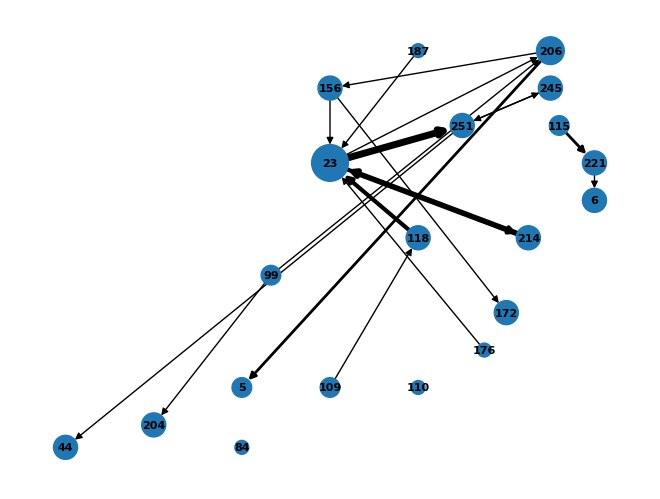

In [95]:
my_graph = Graph()
# get the current time in seconds since the epoch
start = time.time()

graph = Graph()

for i in staten_island_zones['LocationID']:
    graph.add_vertex(i)

for i in range(len(Staten_Island_trips)):
    graph.add_edge(Staten_Island_trips['DOLocationID'][i], Staten_Island_trips['PULocationID'][i], 1)

end = time.time()
print("Time to Create Graph:", end-start)

graph.visualize()

In [30]:
G

In [29]:
graph

In [48]:


# Create a directed graph
#G = nx.DiGraph()
#G.add_edges_from([(1, 2), (2, 3), (3, 2), (4, 2), (1, 2)])

# Calculate in-degrees
#in_degrees = dict(graph.in_degree())

# Set node size based on in-degrees
node_size = [data['incoming_edges'] * 100 for vertex, data in self.adjacency_list.items()]
node_positions = {1: (0, 0), 2: (1, 1), 3: (2, 0), 4: (1, -5)}

# Draw the graph
nx.draw(graph, pos=node_positions, with_labels=True, node_size=node_size, node_color='skyblue', font_size=8, font_color='black', font_weight='bold')
plt.show()

NameError: name 'self' is not defined